## Object Detection

## Setup

In [1]:
from PIL import Image
from matplotlib import pyplot as plt
import matplotlib
import numpy as np
import pickle
from collections import Counter
import cv2

from tensorflow.keras.models import load_model

## Hyperparameter

In [17]:
label_name = np.array(['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']) 

image_file_1 = "C:/Users/yukic/OneDrive/git/object_detection/images/airplane_02.jpg"
idx_target = 0

model_path_1 = "C:/Users/yukic/OneDrive/git/object_detection/models/model_2.h5"

input_size = 32
channel = 3

# we divide the image with the below value to get a lower resolution image
RESIZE = 32

cutoff = 0.999

filename_1 = 'idx_matrix_x32_airplane_02_model_2.sav'
filename_2 = 'prob_matrix_x32_airplane_02_model_2.sav'

imagename_1 = "max_prob_matrix_airplane_02_model2"
imagename_2 = "target_prob_matrix_airplane_02_model2"
imagename_3 = "multi_box_airplane_02_model2"
imagename_4 = "single_box_airplane_02_model2"

title_1 = "Max probs matrix (Model 2)"
title_2 = "Target probs matrix (Model 2)"
title_3 = "Bounding boxes extraction (Model 2)"
title_4 = "Model 2"

## Load images

Height: 2726
Width: 4096
Channel: RGB
Height multiplied by width: 11,165,696


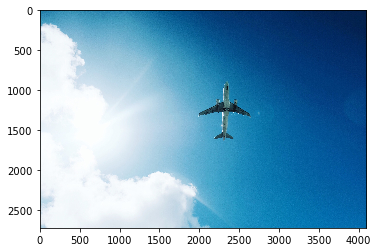

In [7]:
img_1 = Image.open(image_file_1)
print("Height:", img_1.size[1])
print("Width:", img_1.size[0])
print("Channel:", img_1.mode)
print("Height multiplied by width: {:,}".format(img_1.size[0] * img_1.size[1]))

plt.imshow(img_1)
plt.show()

## Load trained model

In [4]:
loaded_model = load_model(model_path_1)
loaded_model.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_22 (Conv2D)           (None, 32, 32, 32)        896       
_________________________________________________________________
activation_38 (Activation)   (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_23 (Conv2D)           (None, 32, 32, 32)        9248      
_________________________________________________________________
batch_normalization_v1_14 (B (None, 32, 32, 32)        128       
_________________________________________________________________
activation_39 (Activation)   (None, 32, 32, 32)        0         
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_24 (Conv2D)           (None, 16, 16, 64)       

## Resize

Resized to (128, 85)
New height 85
New width 128
Number of prediction: 10,880


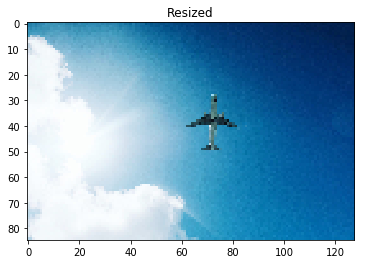

In [10]:
# resize (PIL resize is (width, height), not (height, width))
new_width = img_1.size[0] // RESIZE
new_height = img_1.size[1] // RESIZE
img_1_x = img_1.resize((new_width, new_height))

print("Resized to", img_1_x.size)
print("New height", new_height)
print("New width", new_width)
print("Number of prediction: {:,}".format(new_height*new_width))

plt.imshow(img_1_x)
plt.title("Resized")
plt.show()

## Preprocess

In [12]:
img_1_x_ar = np.array(img_1_x)

# in numpy, we operate by first height, second width
img_1_x_proc = img_1_x_ar.reshape((-1, new_height, new_width, channel))
img_1_x_proc = img_1_x_proc.astype("float32")
img_1_x_proc /= 255

print("Size of preprocessed image", img_1_x_proc.shape)

Size of preprocessed image (1, 85, 128, 3)


## Prediction

In [13]:
# update prediction range
pred_height = new_height - input_size + 1
pred_width = new_width - input_size + 1
print("Prediction matrix has {} by {}".format(pred_height, pred_width))

Prediction matrix has 54 by 97


In [14]:
# prediction

# in numpy, we operate by first height, second width 
idx_matrix_x = np.zeros((pred_height, pred_width))
prob_matrix_x = np.zeros((pred_height, pred_width))

# target matrix
target_prob_matrix = np.zeros((pred_height, pred_width))

img_proc = img_1_x_proc

# sliding windows
for j in range(pred_height):
    for i in range(pred_width):
        # in numpy, we operate by first height, second width 
        tmp = img_proc[:, j:(input_size+j), i:(input_size+i), :]
        pred_tmp = loaded_model.predict(tmp)
        idx_max = np.argmax(pred_tmp)
        prob_max = np.max(pred_tmp)
        
        # target prob
        prob_target = pred_tmp[0][idx_target]

        # store values
        idx_matrix_x[j, i] = idx_max
        prob_matrix_x[j, i] = prob_max
        target_prob_matrix[j, i] = prob_target

## Visualize predictions

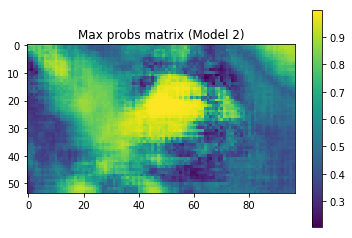

In [18]:
plt.imshow(prob_matrix_x)
plt.title(title_1)
plt.colorbar()
plt.savefig(imagename_1)
plt.show()

Maximum probability of target: 0.9999


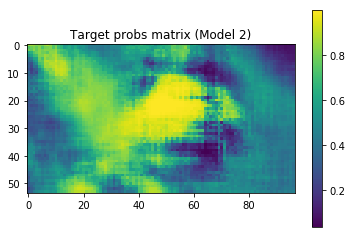

In [19]:
print("Maximum probability of target:", np.round(np.max(target_prob_matrix), decimals = 4))

plt.imshow(target_prob_matrix)
plt.title(title_2)
plt.colorbar()
plt.savefig(imagename_2)
plt.show()

In [20]:
# save
pickle.dump(idx_matrix_x, open(filename_1, 'wb'))
pickle.dump(prob_matrix_x, open(filename_2, 'wb'))

## Load predictions

In [21]:
idx_matrix_x = pickle.load(open(filename_1, 'rb'))
prob_matrix_x = pickle.load(open(filename_2, 'rb'))

## Extract confident bounding boxes

In [22]:
prob_array_x = prob_matrix_x.flatten(order = "C")

location_x = []

# size
n_prob_height = prob_matrix_x.shape[0]
n_prob_width = prob_matrix_x.shape[1]
ratio_height = (img_1.size[1] - input_size * RESIZE + 1) / n_prob_height
ratio_width = (img_1.size[0] - input_size * RESIZE + 1) / n_prob_width


for i in range(n_prob_height):
    for j in range(n_prob_width):
        tmp = [int(np.round(i * ratio_height, decimals = 0)), 
               int(np.round(j * ratio_width, decimals = 0)), 
               int(input_size * RESIZE + np.round(i * ratio_height, decimals = 0)), 
               int(input_size * RESIZE + np.round(j * ratio_width, decimals = 0))]
        
        # adjust edges
        #tmp = [160 if point > 160 else point for point in tmp
        
        # store location infomation
        location_x.append(tmp)
                        
# number of bounding boxes with prespecified cutoff
print(sum(prob_array_x > cutoff))

confident_location_x = np.array(location_x)[prob_array_x > cutoff]
print(confident_location_x)

31
[[ 631 1521 1655 2545]
 [ 631 1552 1655 2576]
 [ 631 1584 1655 2608]
 [ 662 1457 1686 2481]
 [ 662 1489 1686 2513]
 [ 662 1521 1686 2545]
 [ 662 1552 1686 2576]
 [ 662 1584 1686 2608]
 [ 662 1616 1686 2640]
 [ 662 1647 1686 2671]
 [ 662 1679 1686 2703]
 [ 662 1711 1686 2735]
 [ 694 1426 1718 2450]
 [ 694 1457 1718 2481]
 [ 694 1489 1718 2513]
 [ 694 1521 1718 2545]
 [ 694 1552 1718 2576]
 [ 694 1584 1718 2608]
 [ 694 1616 1718 2640]
 [ 694 1647 1718 2671]
 [ 694 1679 1718 2703]
 [ 725 1457 1749 2481]
 [ 725 1489 1749 2513]
 [ 725 1521 1749 2545]
 [ 725 1552 1749 2576]
 [ 725 1584 1749 2608]
 [ 725 1616 1749 2640]
 [ 757 1457 1781 2481]
 [ 757 1489 1781 2513]
 [ 757 1521 1781 2545]
 [ 757 1552 1781 2576]]


## Draw multiple bounding boxes

Number of bounding boxes: 31


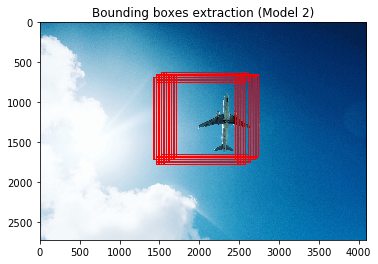

In [25]:
print("Number of bounding boxes:", sum(prob_array_x > cutoff))

tmp_x = np.copy(np.array(img_1))

for pt1_1, pt1_2, pt2_1, pt2_2 in confident_location_x:
    tmp_x = cv2.rectangle(img = tmp_x, pt1 = (pt1_2, pt1_1), pt2 = (pt2_2, pt2_1), color = (255, 0, 0), thickness = 15)
    
plt.imshow(tmp_x)
plt.title(title_3)
plt.savefig(imagename_3)
plt.show()

## Suppressing boxes

In [28]:
n = len(confident_location_x)

loc_1 = []
for i in range(n):
    loc_1.append(confident_location_x[i][0])
    
loc_2 = []
for i in range(n):
    loc_2.append(confident_location_x[i][1])
    
loc_3 = []
for i in range(n):
    loc_3.append(confident_location_x[i][2])
    
loc_4 = []
for i in range(n):
    loc_4.append(confident_location_x[i][3])
    
loc_all = []

### taking mean
loc_all.append(int(np.mean(loc_1)))
loc_all.append(int(np.mean(loc_2)))
loc_all.append(int(np.mean(loc_3)))
loc_all.append(int(np.mean(loc_4)))
print(loc_all)

[692, 1552, 1716, 2576]


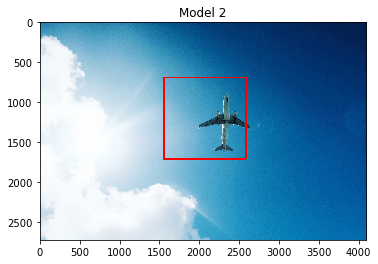

In [29]:
tmp_1 = np.copy(np.array(img_1))

pt1_1, pt1_2, pt2_1, pt2_2 = loc_all
tmp_1 = cv2.rectangle(img = tmp_1, pt1 = (pt1_2, pt1_1), pt2 = (pt2_2, pt2_1), color = (255, 0, 0), thickness = 20)

plt.imshow(tmp_1)
plt.title(title_4)
plt.show()

## Object labeling

In [34]:
### label
idx_array_x = idx_matrix_x.flatten(order = "C")
confident_idx_x = idx_array_x[prob_array_x > cutoff]
label_index = int(Counter(confident_idx_x).most_common(1)[0][0])
label_pred = label_name[label_index]
print(confident_idx_x)
print(Counter(confident_idx_x))
print(label_index)
print(label_pred)

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0.]
Counter({0.0: 31})
0
airplane


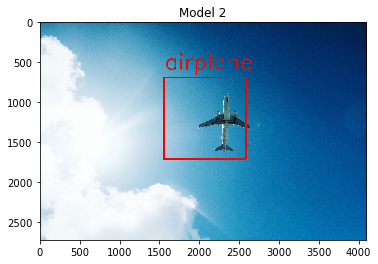

In [33]:
tmp_1 = np.copy(np.array(img_1))

pt1_1, pt1_2, pt2_1, pt2_2 = loc_all
tmp_1 = cv2.rectangle(img = tmp_1, pt1 = (pt1_2, pt1_1), pt2 = (pt2_2, pt2_1), color = (255, 0, 0), thickness = 20)
tmp_1 = cv2.putText(img = tmp_1, 
                    text = label_pred, 
                    org = (pt1_2 + 10, pt1_1 - 100), 
                    fontFace = cv2.FONT_HERSHEY_SIMPLEX, 
                    fontScale = 9, 
                    color = (255, 0, 0),
                    thickness = 20)

plt.imshow(tmp_1)
plt.title(title_4)
plt.savefig(imagename_4)
plt.show()